## Image Segmentation using MONAI & Pytorch
**Monai is a Pytorch-framework**
<br>

We will be creating a **UNet** based architecture

# Importing Libraries

In [1]:
!pip install monai

     |████████████████████████████████| 721 kB 888 kB/s            


In [2]:
import os
import monai
import torch,torchvision
import skimage
import numpy as np 
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Spacingd,
    Resized,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensor,
    ToTensord,
    Orientationd,
    NormalizeIntensityd,
    RandRotated,
    RandAxisFlipd,
    RandFlipd,
    AdjustContrastd,
)
print_config()

MONAI version: 0.8.1
Numpy version: 1.20.3
Pytorch version: 1.9.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 8.2.0
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.1
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.12.5
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Loading The Data
Loading and performing operations on medical dataset is quite tricky to get started with. Since unlike **png**, **jpg** which in general we are used to, <br> we may have to deal with images with different file types like **DICOM**, **NifTi** e.t.c. .
And the file type which we will be dealing with is **TIFF**.



## Understanding the dataset
Lgg-mri-segmentation containes a folder kaggle_3m which contains several data points or folders that  represents individual patients. <br>
And each patient have certain no of slices in the voxel.(images of various slices of the brain).  <br>
**We will create two arrays  containing file name of Brain MRI and there respective Masks.** 

In [3]:
# Mask Files
mask_files = sorted(glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*'))#

In [4]:
# Brain MRI Images
training_files = []
for path in mask_files:
    training_files.append(path.replace('_mask',''))

# Visualization of data

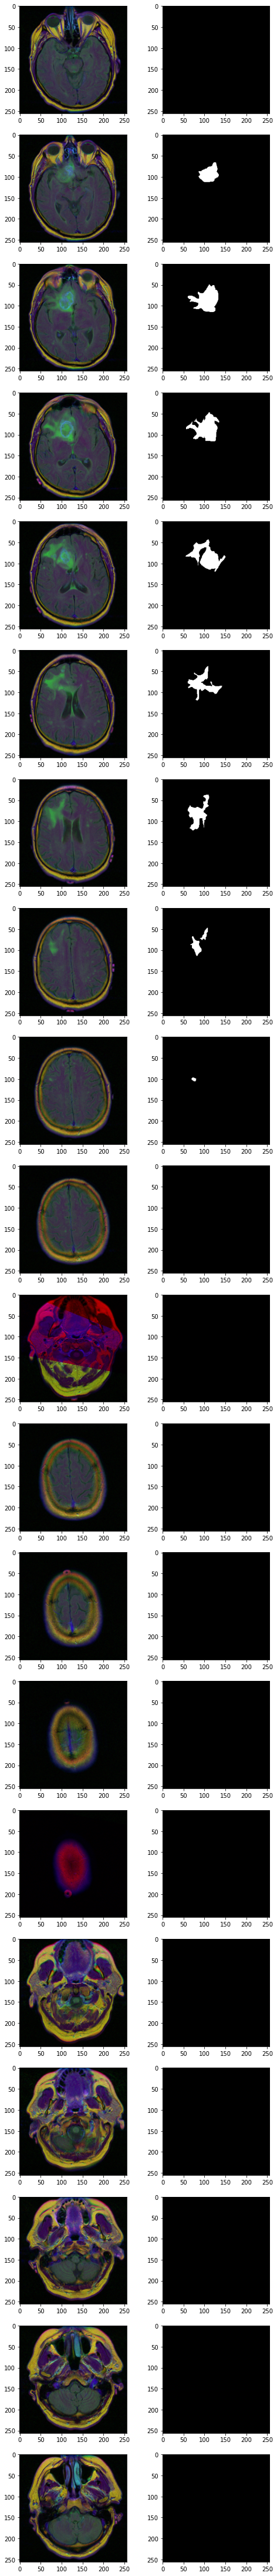

In [5]:
rows = 20
fig,ax = plt.subplots(rows,2,figsize=(8,80))
for i in range(rows):
    read1 = plt.imread(training_files[i])
    read2 = plt.imread(mask_files[i])
    ax[i,0].imshow(read1)
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

So we can see that there are cases in which we dont have masks these cases can leed to difficulty in the learninig of our model.

In [6]:
# will tell us if a image has mask or not
def is_mask(path):
    mask = plt.imread(path)
    if np.max(mask) != 0.0:
        return 1
    else:
        return 0

In [7]:
df = pd.DataFrame({'training_files':training_files,'mask_files':mask_files})
df['mask'] = df['mask_files'].apply(lambda x: is_mask(x))

In [8]:
df.head()

training_files  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   

                                          mask_files  mask  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     0  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     1

In [9]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

So lets reorganize or data to only containe data points with Masks

In [10]:
data = df[df['mask']==1]

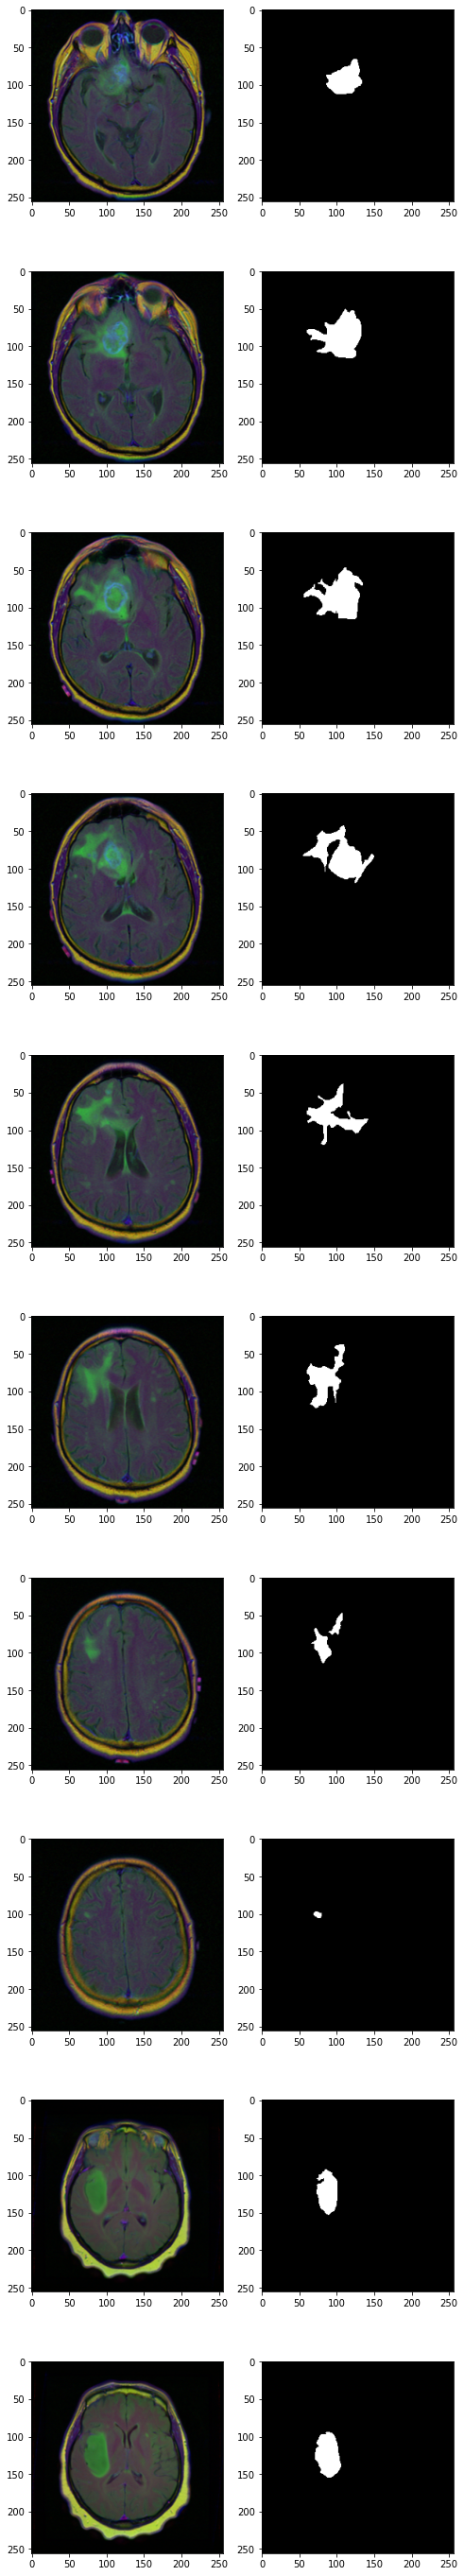

In [11]:
rows = 10
fig,ax = plt.subplots(rows,2,figsize=(8,50))
for i in range(rows):
    read1 = plt.imread(data['training_files'].iloc[i])
    read2 = plt.imread(data['mask_files'].iloc[i])
    ax[i,0].imshow(read1,cmap='gray')
    ax[i,1].imshow(read2,cmap='gray')
plt.show()

# Data Preprations
In this section we will do two✌ steps--

1. Converting the images from .tff to .nii format since it is a very efficient way when using monai or with medical data in general.

2. Converting the colored images into GrayScale images since It will reduce the model coplexity a lot. I  builded a model with colored data too but found that it was having difficulty in converging as compared to grayscale images.

In [12]:
# Creating Dir to store the converted files
dir = './new_data'
mask_out_path = './new_data/mask'
input_out_path = './new_data/input'
os.mkdir(dir)
os.mkdir(mask_out_path)
os.mkdir(input_out_path)

In [13]:
# This library will help in convention
!pip install imio

  Preparing metadata (setup.py) ... done
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34546 sha256=fcfd89fa33ddad84abb30e6a1d818e9f9860912769edc41cdb1599f8c8b40702
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


In [14]:
from imio import load, save

In [15]:
# Traning Files
for path in data['training_files']:
    img = plt.imread(path)
    img = skimage.color.rgb2gray(img)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(input_out_path,name))

In [16]:
# Mask Files
for path in data['mask_files']:
    img = plt.imread(path)
    name = os.path.basename(os.path.normpath(path))
    name = os.path.splitext(name)[0]
    save.to_nii(img, "{}/{}.nii.gz".format(mask_out_path,name))

# Preprocessing & Data Augmentation 

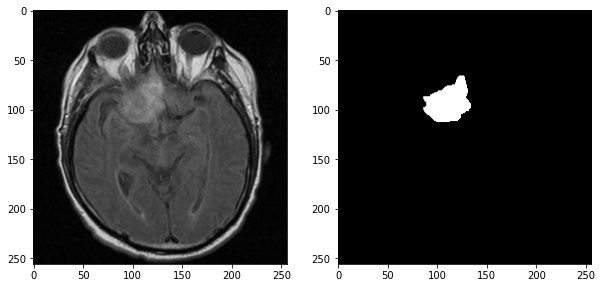

In [17]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
img = skimage.color.rgb2gray(plt.imread(data['training_files'].iloc[0]))
mask = plt.imread(data['mask_files'].iloc[0])
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,cmap='gray')

From the Above images we can identify two✌ things
1. The size of the image is **250x250** which is large enough cause issues while fitting in the** GPU Memory**.

2. As we can see that It is difficult to see the tumor in the Brain MRI. To resolve this we can **strach contrast** accordingly. 

In [18]:
# First we have to get that .nii data
filenames = []
img = sorted(glob('./new_data/input/*'))
mask = sorted(glob('./new_data/mask/*'))
for i in range(len(img)):
    filenames.append({'img':img[i],'mask':mask[i]})

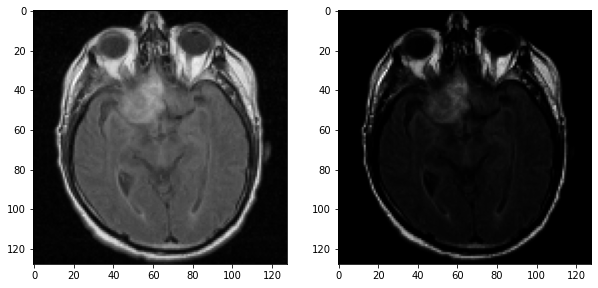

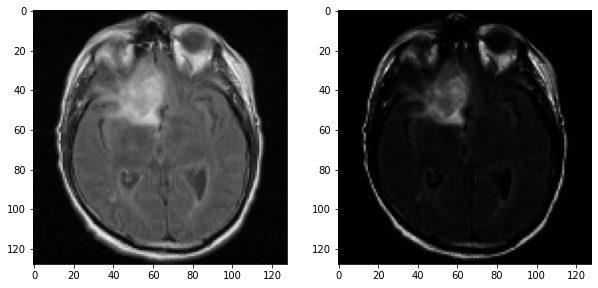

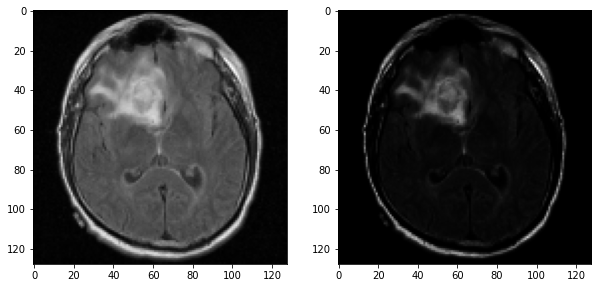

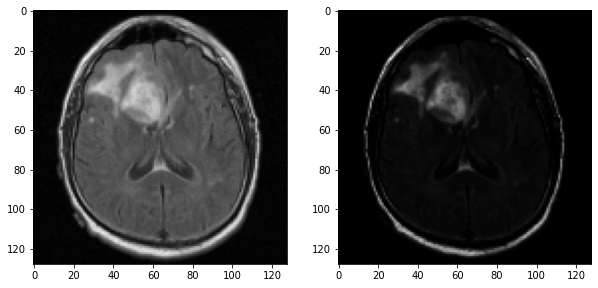

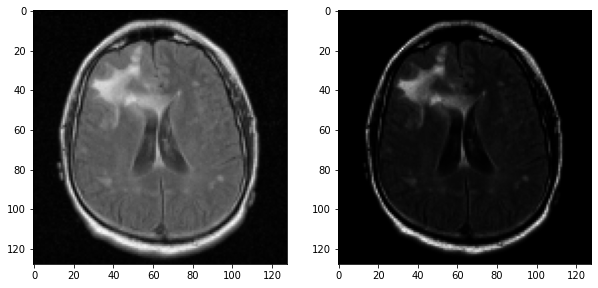

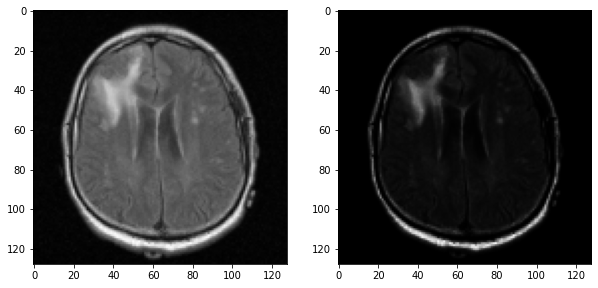

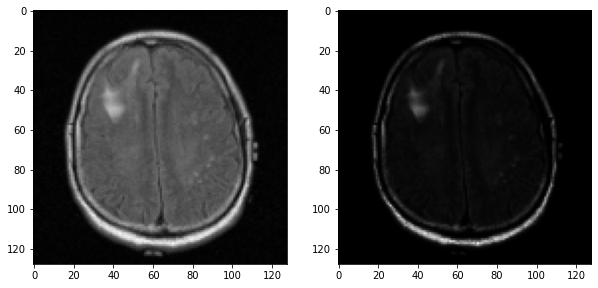

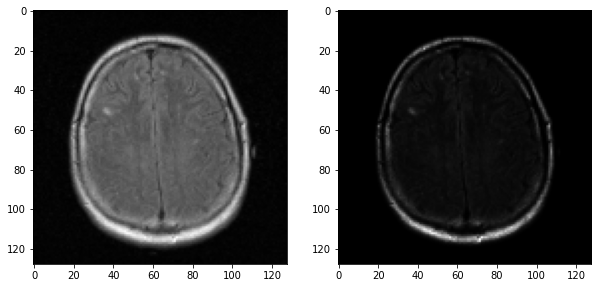

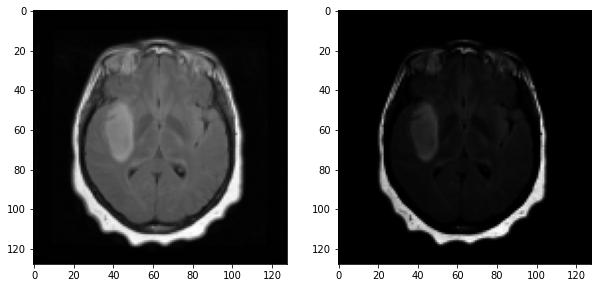

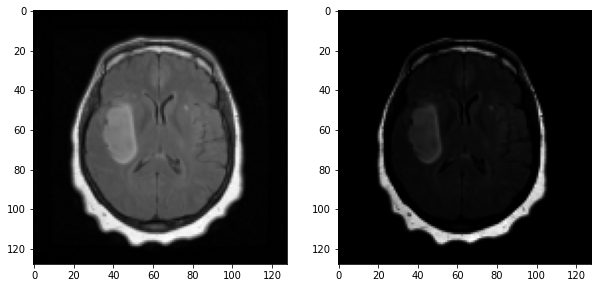

In [19]:
for i in range(0,10):
  li = LoadImaged(keys=['img','mask'])
  li_img = li(filenames[i])
  li_img['img'].shape
  add = AddChanneld(keys=['img','mask'])
  add_img = add(li_img)
  res = Resized(spatial_size  = (128,128),keys=['img'])
  res_img = res(add_img)
  res_img['img'].shape
  si = AdjustContrastd(keys=["img"],gamma=3)
  si_img = si(res_img)
  fig,ax = plt.subplots(1,2,figsize=(10,5))
  ax[0].imshow(res_img['img'][0,:,:],cmap='gray')
  ax[1].imshow(si_img['img'][0,:,:],cmap='gray')

In [20]:
org_img = Compose([
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),
])
preprocess = Compose([
    
    LoadImaged(keys=['img','mask']),
    AddChanneld(keys=['img','mask']),
    Resized(spatial_size  = (128,128),keys=['img','mask']),
    AdjustContrastd(keys="img",gamma=2),
    NormalizeIntensityd(keys=['img','mask'],divisor=255.0,subtrahend=0),
    ToTensor(),  
    
])


In [21]:
# Preparing the DataSet
train_data = Dataset(data = filenames,transform = preprocess)

In [22]:
from torch.utils.data import random_split
val = int((len(train_data)/100)*30) # 30%
org = len(train_data)-val
print(val,org)
train_ds,val_ds = random_split(train_data,[org,val])

411 962


In [23]:
train_loder = DataLoader(train_ds,batch_size = 1)
val_loder = DataLoader(val_ds,batch_size = 1)

# Building the UNet Model

In [24]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

### Model from Scratch

In [25]:
class ConvBlock(nn.Module):
    
    def __init__(self,input_ch,output_ch,kernal_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_ch,output_ch,kernal_size)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(output_ch,output_ch,kernal_size)

    def forward(self,x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
    
class Encoder(nn.Module):
    def __init__(self,layers=[3,64,128,256,512,1024],kernal_size = 3,pool = 2):
        super().__init__()
        self.encoder = nn.ModuleList([ConvBlock(layers[i],layers[i+1],kernal_size) for i in range(len(layers)-1)])
        self.pool_layer = nn.MaxPool2d(pool)

    def forward(self,x):
        encoder = []
        for block in self.encoder:
           
            x = block(x)
            encoder.append(x)
            x = self.pool_layer(x)
        return encoder

class Decoder(nn.Module):
    def __init__(self,layers = [1024,512,256,128,64],kernal_size=3):
        super().__init__()
        self.layers = layers
        self.decoder = nn.ModuleList([ConvBlock(layers[i],layers[i+1],kernal_size) for i in range(len(layers)-1)])
        self.upconv  = nn.ModuleList([nn.ConvTranspose2d(layers[i],layers[i+1],2,2) for i in range(len(layers)-1)])
        
    def forward(self,x,encoder):
        for i in range(len(self.layers)-1):
            x = self.upconv[i](x) 
            connect = self.crop(encoder[i],x)
            x = torch.cat([x,connect],dim=1)
            x = self.decoder[i](x)
        return x
    
    def crop(self,input_tensor,target_tensor):
        _,_,H,W = target_tensor.shape
        reshaped   = torchvision.transforms.CenterCrop([H, W])(input_tensor)
        return reshaped

In [26]:
class Unet(nn.Module):
    def __init__(self,encoder_layers=[3,64,128,256],decoder_layers = [256,128,64],retain_dimension = True, num_class = 1,outputsize = (128,128) ):
        super().__init__()
        self.encoder = Encoder(encoder_layers)
        self.decoder = Decoder(decoder_layers)
        self.output = nn.Conv2d(decoder_layers[-1],num_class,1)
        self.retain_dimension = retain_dimension
        self.outputsize = outputsize
        
    def forward(self,x):
        enco = self.encoder(x)
        output = self.decoder(enco[::-1][0],enco[::-1][1:])
        output = self.output(output)
        if self.retain_dimension:
            output = F.interpolate(output,self.outputsize)
        return output

In [27]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = torch.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

### Model from Monai

In [28]:
device='cuda'

In [29]:
model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64,128,256,512),
        dropout=0.3,
        strides=(2, 2, 2, 2,2),
        num_res_units=3,
    ).to(device)

In [30]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [31]:
num_epochs = 40
epoch_loss_values = []
val_loss_values = []

### Model Traning

In [32]:
# Model Traning
for epoch in (range(num_epochs)):
        print("-" * num_epochs)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        avg_val_loss = 0
        step = 0
        print('traning')
        for batch_data in tqdm(train_loder):
            step += 1
            inputs, labels = torch.reshape(batch_data['img'],(1,1,128,128)).to(device), batch_data['mask'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loder.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        ii = 0
        for batch in tqdm(val_loder):#val_patient
            ii+=1
            inputs, labels = torch.reshape(batch['img'],(1,1,128,128)).to(device), batch['mask'].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            avg_val_loss+=loss.item()
        avg_val_loss = avg_val_loss/ii
        val_loss_values.append(avg_val_loss)
       
        
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f} validation_loss: {avg_val_loss:.4f}")

----------------------------------------
epoch 1/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.34it/s]


epoch 1 average loss: 0.8312 validation_loss: 0.7029
----------------------------------------
epoch 2/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.38it/s]


epoch 2 average loss: 0.5767 validation_loss: 0.5013
----------------------------------------
epoch 3/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.87it/s]


epoch 3 average loss: 0.4801 validation_loss: 0.4742
----------------------------------------
epoch 4/40
traning


100%|██████████| 411/411 [00:07<00:00, 54.22it/s]


epoch 4 average loss: 0.4438 validation_loss: 0.4309
----------------------------------------
epoch 5/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.77it/s]


epoch 5 average loss: 0.4211 validation_loss: 0.4155
----------------------------------------
epoch 6/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.24it/s]


epoch 6 average loss: 0.4110 validation_loss: 0.4064
----------------------------------------
epoch 7/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.41it/s]


epoch 7 average loss: 0.3996 validation_loss: 0.3954
----------------------------------------
epoch 8/40
traning


100%|██████████| 411/411 [00:07<00:00, 53.50it/s]


epoch 8 average loss: 0.3872 validation_loss: 0.3904
----------------------------------------
epoch 9/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.05it/s]


epoch 9 average loss: 0.3740 validation_loss: 0.3989
----------------------------------------
epoch 10/40
traning


100%|██████████| 411/411 [00:07<00:00, 55.91it/s]


epoch 10 average loss: 0.3649 validation_loss: 0.3761
----------------------------------------
epoch 11/40
traning


100%|██████████| 411/411 [00:07<00:00, 53.49it/s]


epoch 11 average loss: 0.3632 validation_loss: 0.3625
----------------------------------------
epoch 12/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.61it/s]


epoch 12 average loss: 0.3550 validation_loss: 0.3668
----------------------------------------
epoch 13/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.71it/s]


epoch 13 average loss: 0.3530 validation_loss: 0.3540
----------------------------------------
epoch 14/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.95it/s]


epoch 14 average loss: 0.3468 validation_loss: 0.3523
----------------------------------------
epoch 15/40
traning


100%|██████████| 411/411 [00:07<00:00, 52.87it/s]


epoch 15 average loss: 0.3408 validation_loss: 0.3591
----------------------------------------
epoch 16/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.91it/s]


epoch 16 average loss: 0.3390 validation_loss: 0.3586
----------------------------------------
epoch 17/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.29it/s]


epoch 17 average loss: 0.3326 validation_loss: 0.3491
----------------------------------------
epoch 18/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.83it/s]


epoch 18 average loss: 0.3327 validation_loss: 0.3389
----------------------------------------
epoch 19/40
traning


100%|██████████| 411/411 [00:07<00:00, 54.39it/s]


epoch 19 average loss: 0.3194 validation_loss: 0.3436
----------------------------------------
epoch 20/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.55it/s]


epoch 20 average loss: 0.3228 validation_loss: 0.3486
----------------------------------------
epoch 21/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.07it/s]


epoch 21 average loss: 0.3156 validation_loss: 0.3357
----------------------------------------
epoch 22/40
traning


100%|██████████| 411/411 [00:07<00:00, 54.09it/s]


epoch 22 average loss: 0.3158 validation_loss: 0.3310
----------------------------------------
epoch 23/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.84it/s]


epoch 23 average loss: 0.3083 validation_loss: 0.3301
----------------------------------------
epoch 24/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.73it/s]


epoch 24 average loss: 0.3113 validation_loss: 0.3469
----------------------------------------
epoch 25/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.86it/s]


epoch 25 average loss: 0.3047 validation_loss: 0.3225
----------------------------------------
epoch 26/40
traning


100%|██████████| 411/411 [00:07<00:00, 54.15it/s]


epoch 26 average loss: 0.3063 validation_loss: 0.3437
----------------------------------------
epoch 27/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.00it/s]


epoch 27 average loss: 0.3020 validation_loss: 0.3317
----------------------------------------
epoch 28/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.74it/s]


epoch 28 average loss: 0.2959 validation_loss: 0.3262
----------------------------------------
epoch 29/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.64it/s]


epoch 29 average loss: 0.2955 validation_loss: 0.3221
----------------------------------------
epoch 30/40
traning


100%|██████████| 411/411 [00:07<00:00, 53.49it/s]


epoch 30 average loss: 0.2911 validation_loss: 0.3236
----------------------------------------
epoch 31/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.04it/s]


epoch 31 average loss: 0.2846 validation_loss: 0.3305
----------------------------------------
epoch 32/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.09it/s]


epoch 32 average loss: 0.2898 validation_loss: 0.3097
----------------------------------------
epoch 33/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.12it/s]


epoch 33 average loss: 0.2818 validation_loss: 0.3020
----------------------------------------
epoch 34/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.25it/s]


epoch 34 average loss: 0.2812 validation_loss: 0.3170
----------------------------------------
epoch 35/40
traning


100%|██████████| 411/411 [00:07<00:00, 58.31it/s]


epoch 35 average loss: 0.2851 validation_loss: 0.3006
----------------------------------------
epoch 36/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.60it/s]


epoch 36 average loss: 0.2779 validation_loss: 0.3201
----------------------------------------
epoch 37/40
traning


100%|██████████| 411/411 [00:07<00:00, 53.88it/s]


epoch 37 average loss: 0.2752 validation_loss: 0.3085
----------------------------------------
epoch 38/40
traning


100%|██████████| 411/411 [00:07<00:00, 57.47it/s]


epoch 38 average loss: 0.2739 validation_loss: 0.3029
----------------------------------------
epoch 39/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.82it/s]


epoch 39 average loss: 0.2785 validation_loss: 0.3469
----------------------------------------
epoch 40/40
traning


100%|██████████| 411/411 [00:06<00:00, 59.10it/s]

epoch 40 average loss: 0.2690 validation_loss: 0.3094


### Loss vs Epoch

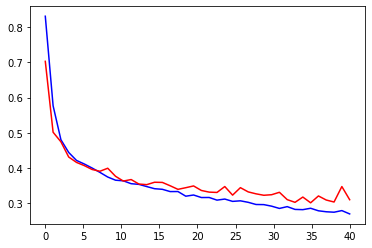

In [33]:
plt.plot(np.linspace(0,len(epoch_loss_values),len(epoch_loss_values)),epoch_loss_values,color='blue')
plt.plot(np.linspace(0,len(val_loss_values),len(val_loss_values)),val_loss_values,color='red')

### Visualizing the Results

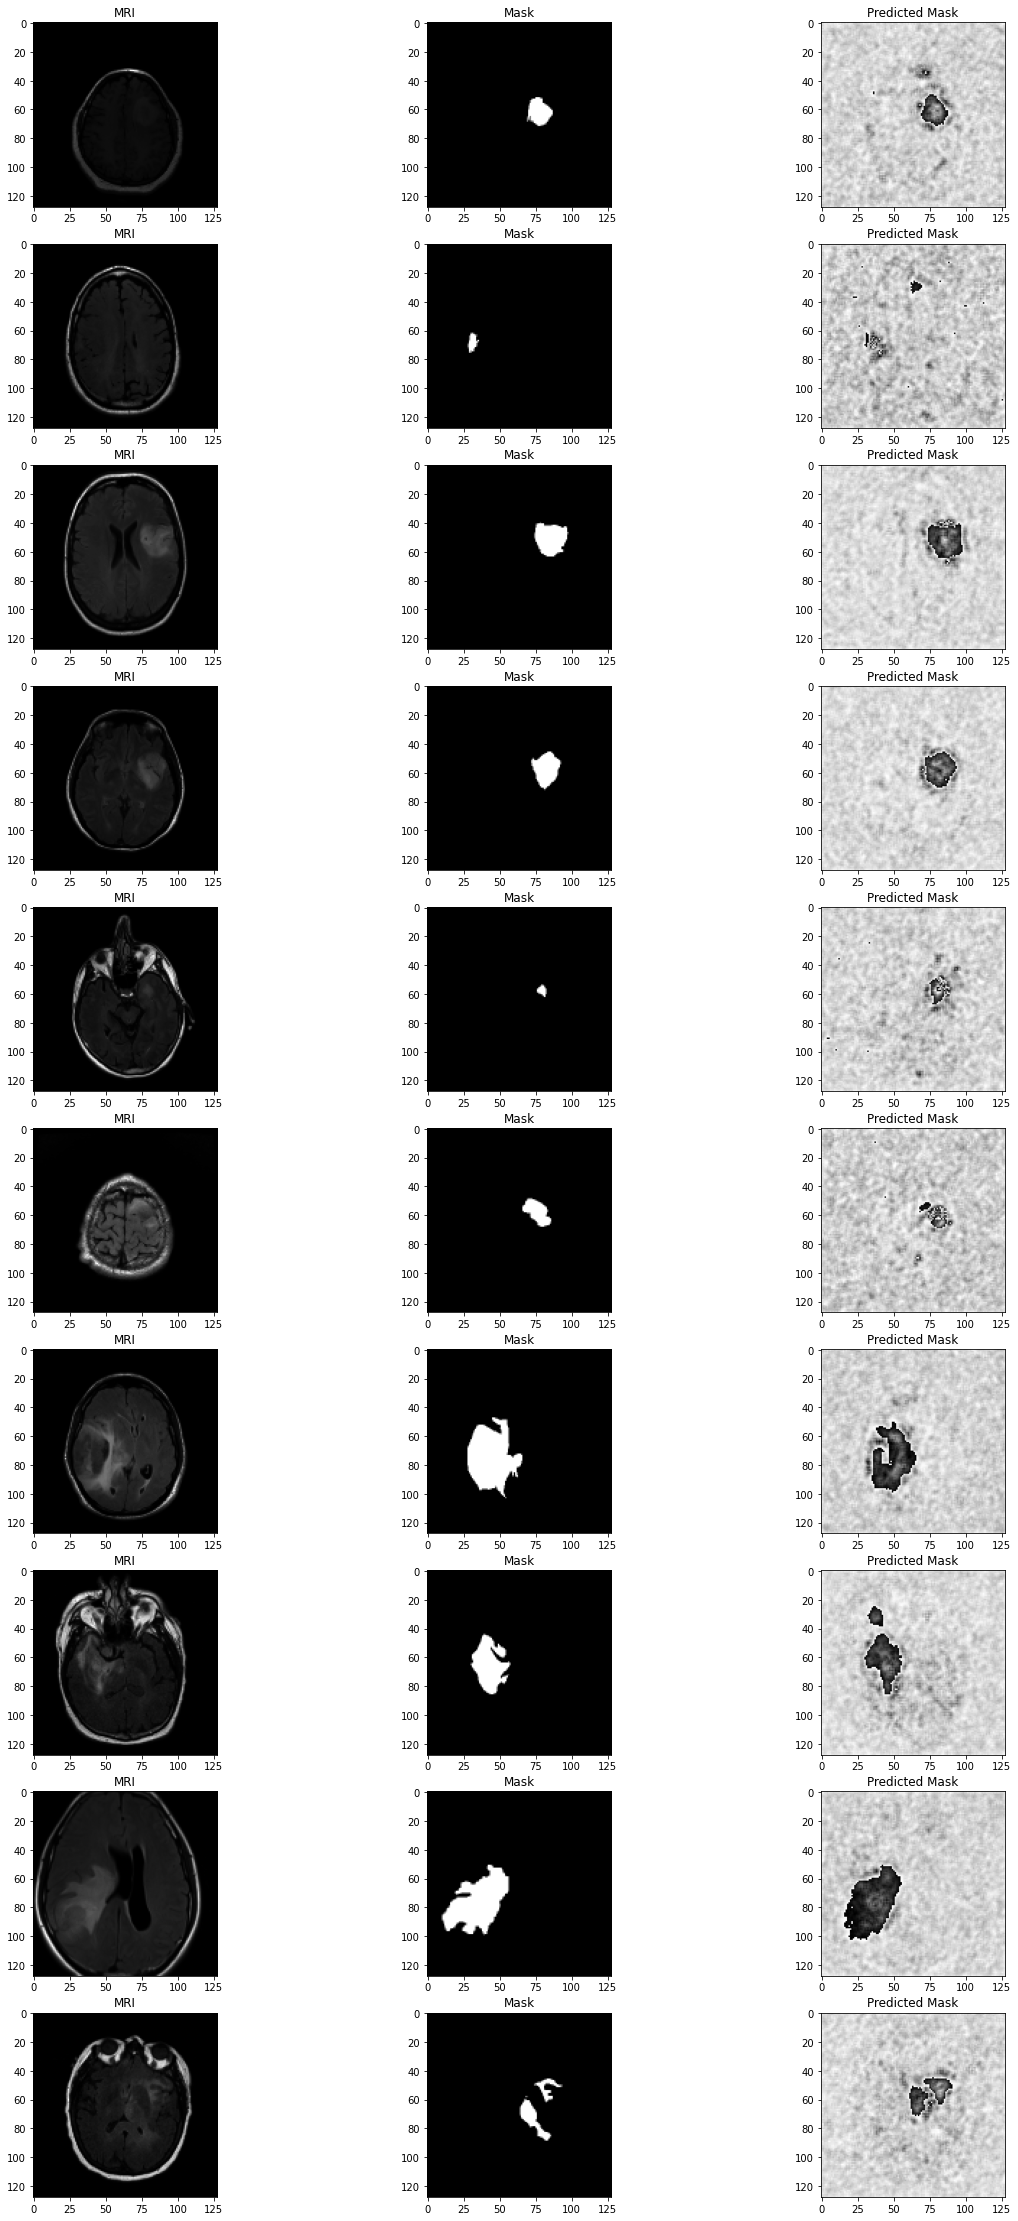

In [34]:
r = 10
i=0
fig,ax = plt.subplots(r,3,figsize=(20,40))
for batch in val_loder:
    inp = torch.reshape(batch['img'],(1,1,128,128)).to(device)
    out = model(inp).to('cpu')
    ax[i,0].imshow(batch['img'][0,0,:,:],cmap='gray')
    ax[i,0].title.set_text('MRI')
    ax[i,1].imshow(batch['mask'][0,0,:,:],cmap='gray')
    ax[i,1].title.set_text('Mask')
    ax[i,2].imshow(out[0,0,:,:].detach().numpy().astype('uint8'),cmap='gray')
    ax[i,2].title.set_text('Predicted Mask')
    if i>=r-1:
        break
    i=i+1
    
      